In [1]:
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F 
import torch.nn as nn 
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup 
import pickle 
import addict 
from scipy.spatial import distance 
import tqdm 
from functools import partial 
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt

# for dimensionality reduction 
import umap 
from hdbscan import HDBSCAN
from hdbscan.flat import HDBSCAN_flat, approximate_predict_flat

In [2]:
dest_dir = "../storage/ipc_title_firstclaim.pkl" 

with open(dest_dir, "rb") as f: 
    embeddings = pickle.load(f) 
    q_v = embeddings['query'] 
    candidate = embeddings['candidate'] 

print(q_v.shape, candidate.shape) 

(50000, 768) (100000, 768)


In [32]:
reducer = umap.UMAP(n_components=2)

embed = reducer.fit_transform(candidate)


In [33]:
embed.shape

(100000, 2)

In [17]:
q_embed = reducer.fit_transform(q_v[0].reshape((-1,768))) 

q_embed.shape

(1, 3)

In [42]:
# apply HDBSCAN 
clusterer = HDBSCAN_flat(embed[:1000],
                         cluster_selection_method='eom') 


In [43]:
labels = clusterer.labels_
proba = clusterer.probabilities_


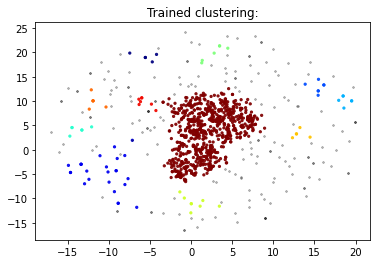

Unique labels (-1 for outliers): [-1  0  1  2  3  4  5  6  7  8  9 10]


In [49]:
plt.title("Trained clustering:")
embed = embed[:1000] 

plt.scatter(embed[labels>=0, 0], embed[labels>=0, 1], c=labels[labels>=0], s=5, alpha=0.9,
            cmap=plt.cm.jet)
plt.scatter(embed[labels<0, 0], embed[labels<0, 1], c='k', s=3, marker='x', alpha=0.3)

plt.show()

print(f"Unique labels (-1 for outliers): {np.unique(labels)}") 

In [30]:
test_labels, test_proba = approximate_predict_flat(clusterer, q_embed) 
test_labels

array([99], dtype=int32)

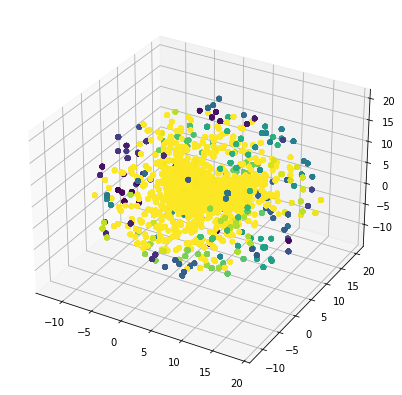

In [31]:
fig = plt.figure(figsize=(10,7)) 
ax = plt.axes(projection = "3d") 
ax.scatter3D(embed[:,0], embed[:,1], embed[:,2], c=labels[labels>=0]) 
plt.show()

In [52]:
labels

array([1, 9, 9, ..., 9, 9, 9])

In [61]:
q_sample = q_v[1] 

q_sample = q_sample.reshape((-1,768))

q_red = reducer.fit_transform(q_sample) 

In [62]:
test_labels, test_proba = approximate_predict_flat(clusterer, q_red) 


In [63]:
test_labels

array([9], dtype=int32)

In [64]:
labels[1]

9

## UMAP ##

In [3]:
import umap
import torch

# n_components 로 target dimension size 지정
reducer = umap.UMAP(n_components=2)

# for example
input_vector = torch.randn(150000, 768)

embed = reducer.fit_transform(input_vector)

print(embed.shape)

(150000, 2)


### 소요시간 측정 ###
|768|2|
|---|---|
|1500|10.3|  
|15000|18.8|
|150000|173.8|

---
|768|3|
|---|---|
|1500|27.2|  
|15000|31.5|
|150000|175.6|

## HDBSCAN ##

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from hdbscan import HDBSCAN
from hdbscan.flat import HDBSCAN_flat, approximate_predict_flat

### Train, Test set 준비 ###

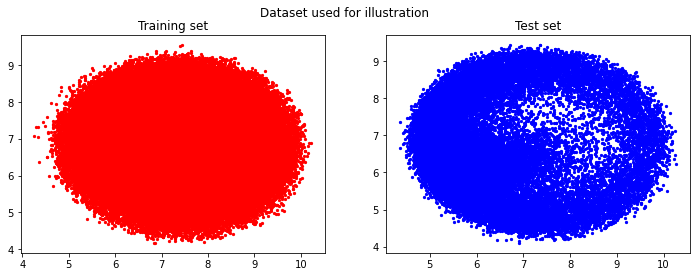

In [20]:
split_idx = embed.shape[0] // 5
X, X_test = embed[split_idx:], embed[:split_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title("Training set")
axes[0].scatter(X[:, 0], X[:, 1], c='r', s=5)
axes[1].set_title("Test set")
axes[1].scatter(X_test[:, 0], X_test[:, 1], c='b', s=5)
plt.suptitle("Dataset used for illustration")
plt.show()

In [21]:
print(X.shape, X_test.shape)

(120000, 2) (30000, 2)


### train ###

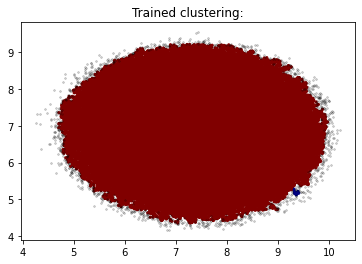

Unique labels (-1 for outliers): [-1  0  1]


In [25]:
# n_clusters 를 None 으로 하면, 알아서 적절하게 clustering 함.
clusterer = HDBSCAN_flat(X,
                         cluster_selection_method='eom',
                         n_clusters=2, min_cluster_size=10)
labels = clusterer.labels_
proba = clusterer.probabilities_

plt.title("Trained clustering:")
plt.scatter(X[labels>=0, 0], X[labels>=0, 1], c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X[labels<0, 0], X[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

### test ###

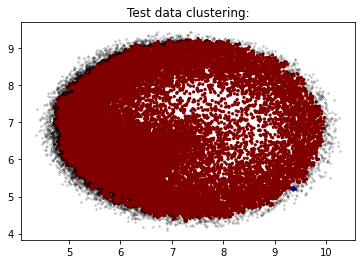

Unique labels (-1 for outliers): [-1  0  1]


In [27]:
# 위에서 학습한 clusterer 활용
labels, proba = approximate_predict_flat(clusterer, X_test, n_clusters=2)

plt.title("Test data clustering:")
plt.scatter(X_test[labels>=0, 0], X_test[labels>=0, 1],
            c=labels[labels>=0], s=5,
            cmap=plt.cm.jet)
plt.scatter(X_test[labels<0, 0], X_test[labels<0, 1],
            c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")